<h1> Task 1 - Setting the baseline <h1>

<h2> Task 1.1 - Data preparation and validation pipeline <h2>

<h3> Import librarys <h3>

In [27]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor      # k-Nearest Neighbors regression model
from sklearn.multioutput import MultiOutputRegressor   # Extend regressors to multi-output problems
import math                                            # Python built-in math library
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os                                              #Python built-in library for operating system interactions
import missingno as msno                               #Library for visualizing missing data
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, cross_validate #Cross-validation utilities
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression 
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split


<h3> Missing data visualization <h3>

<Axes: >

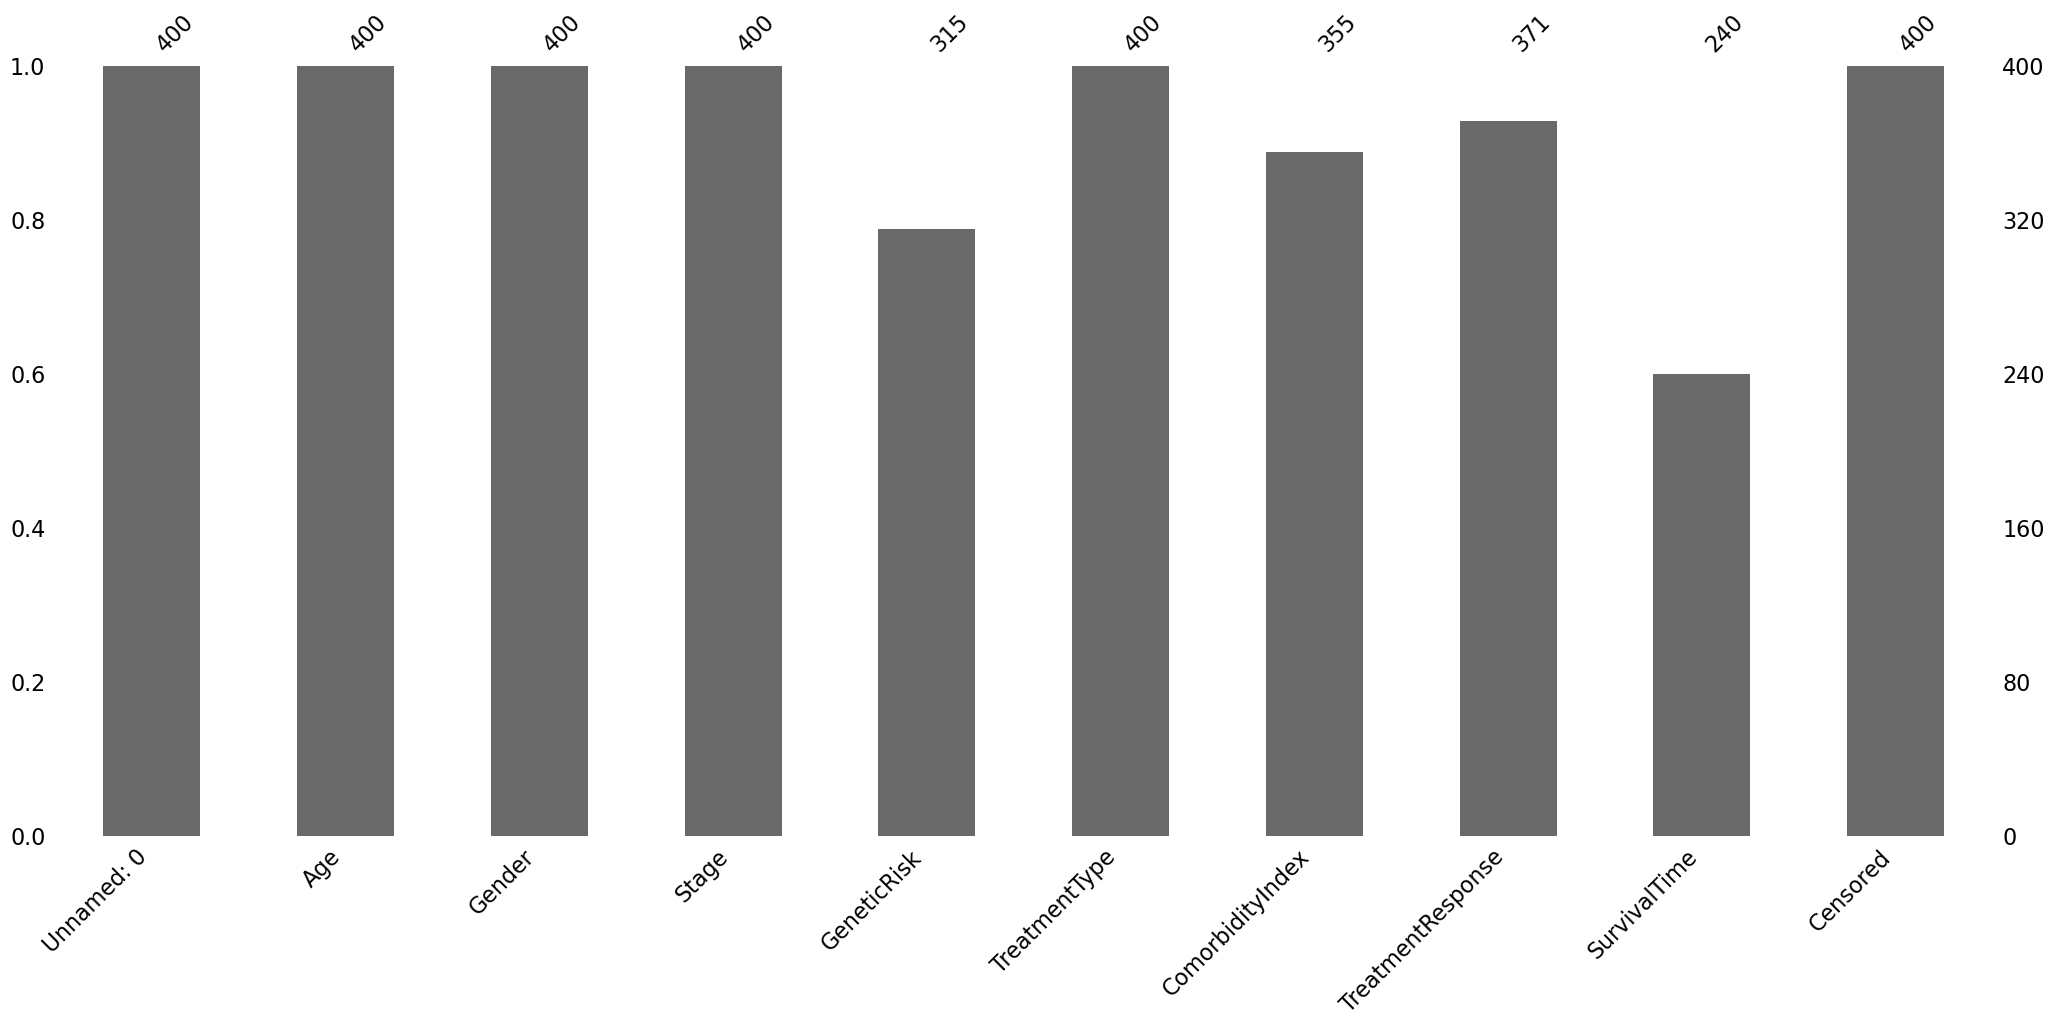

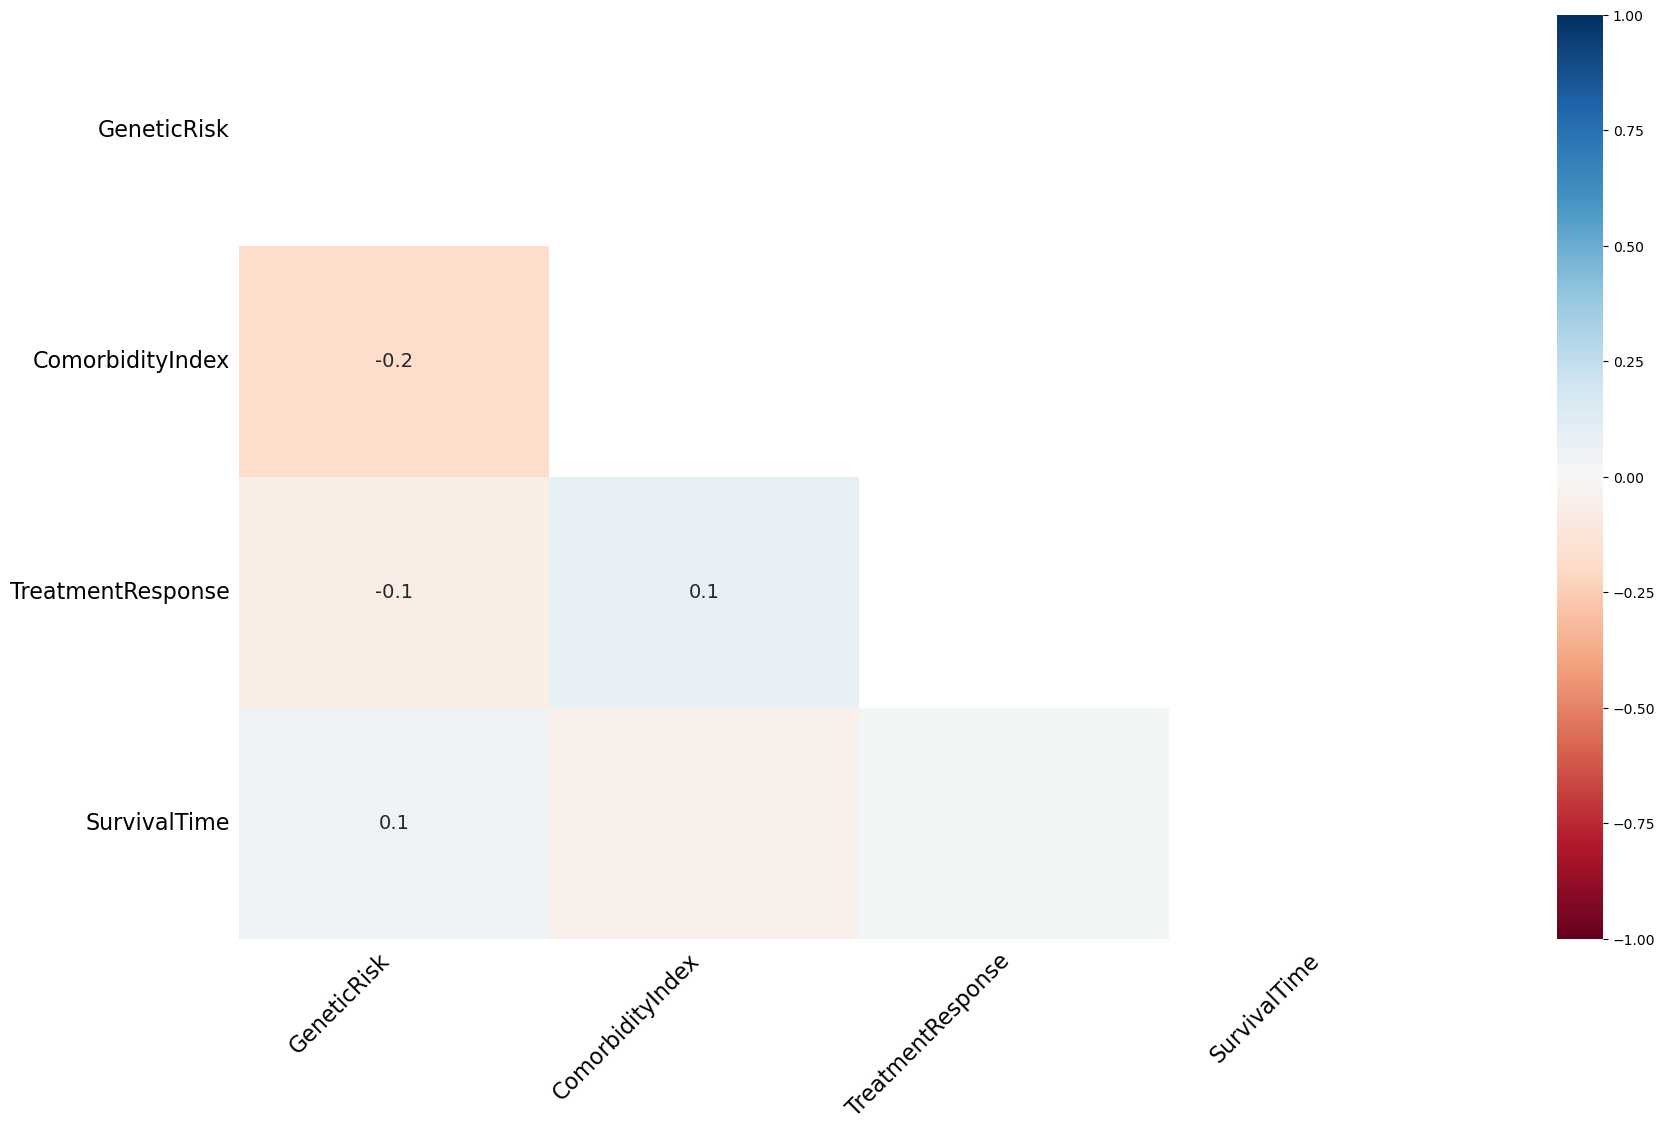

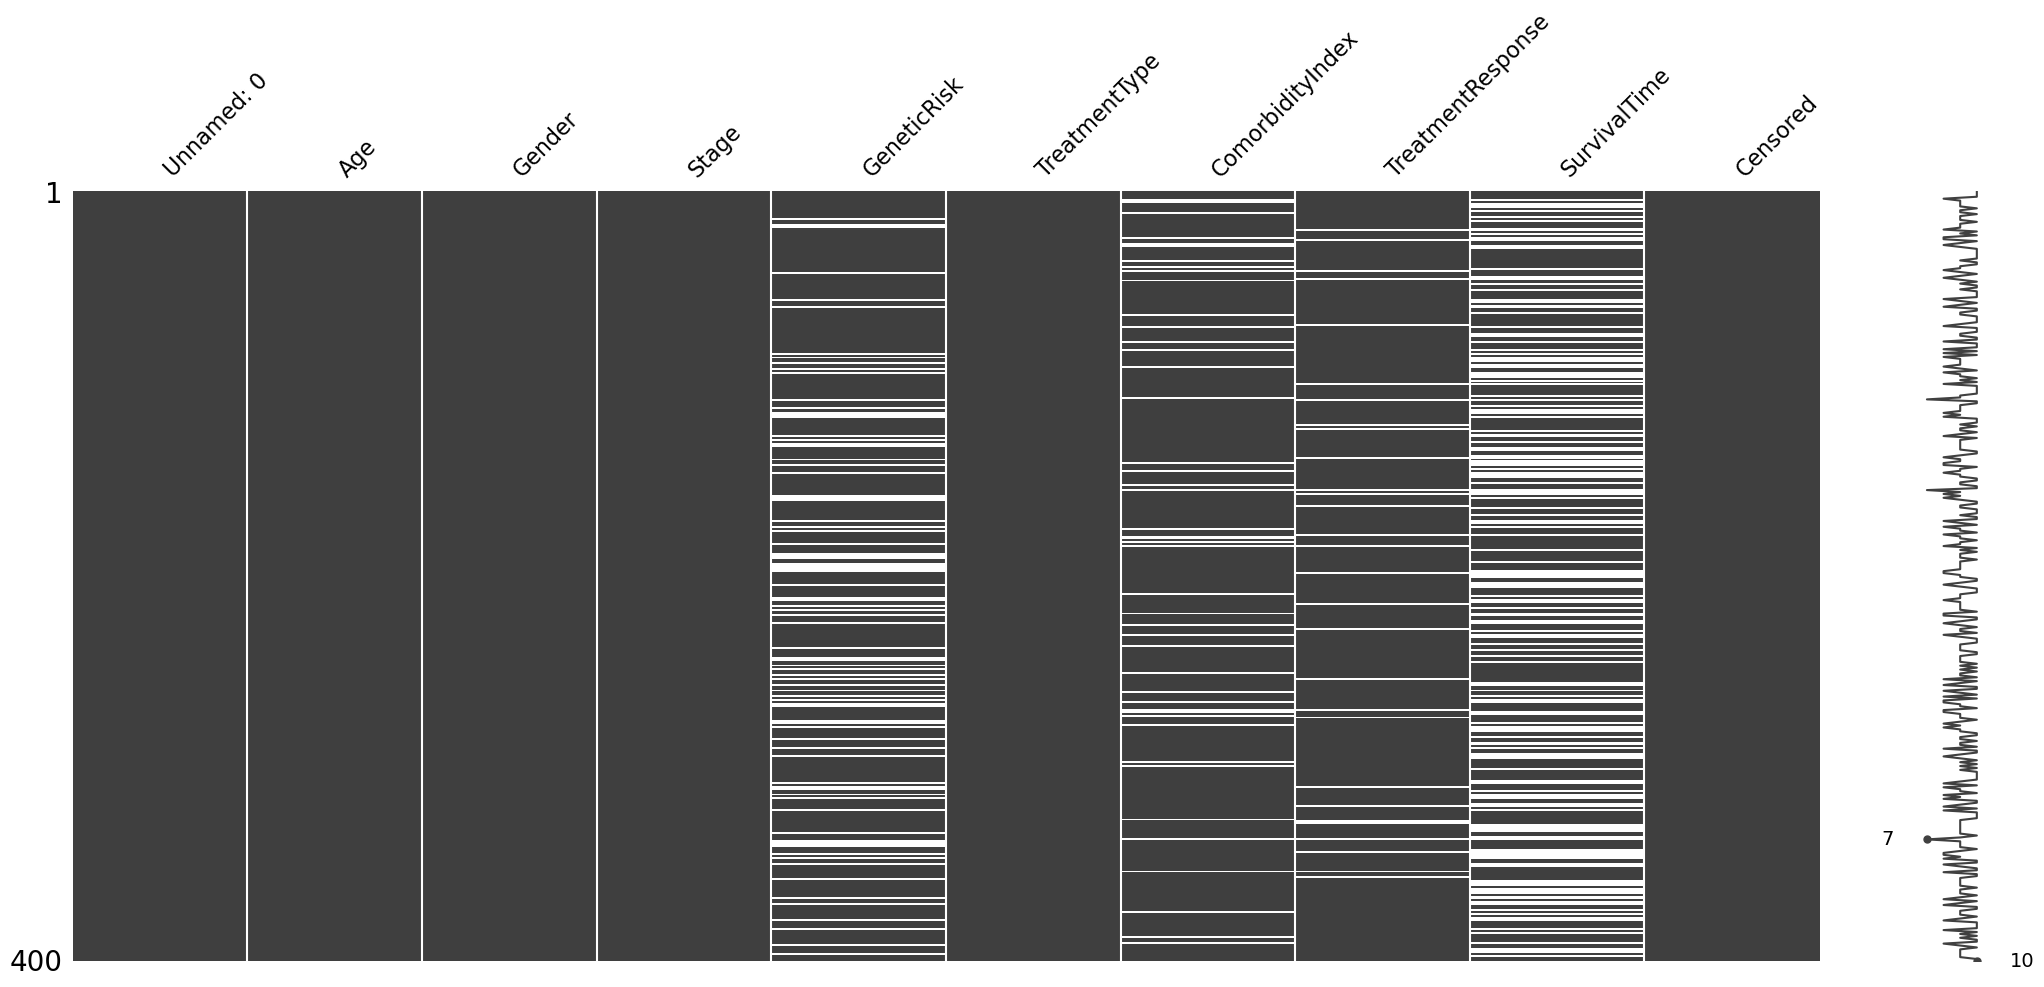

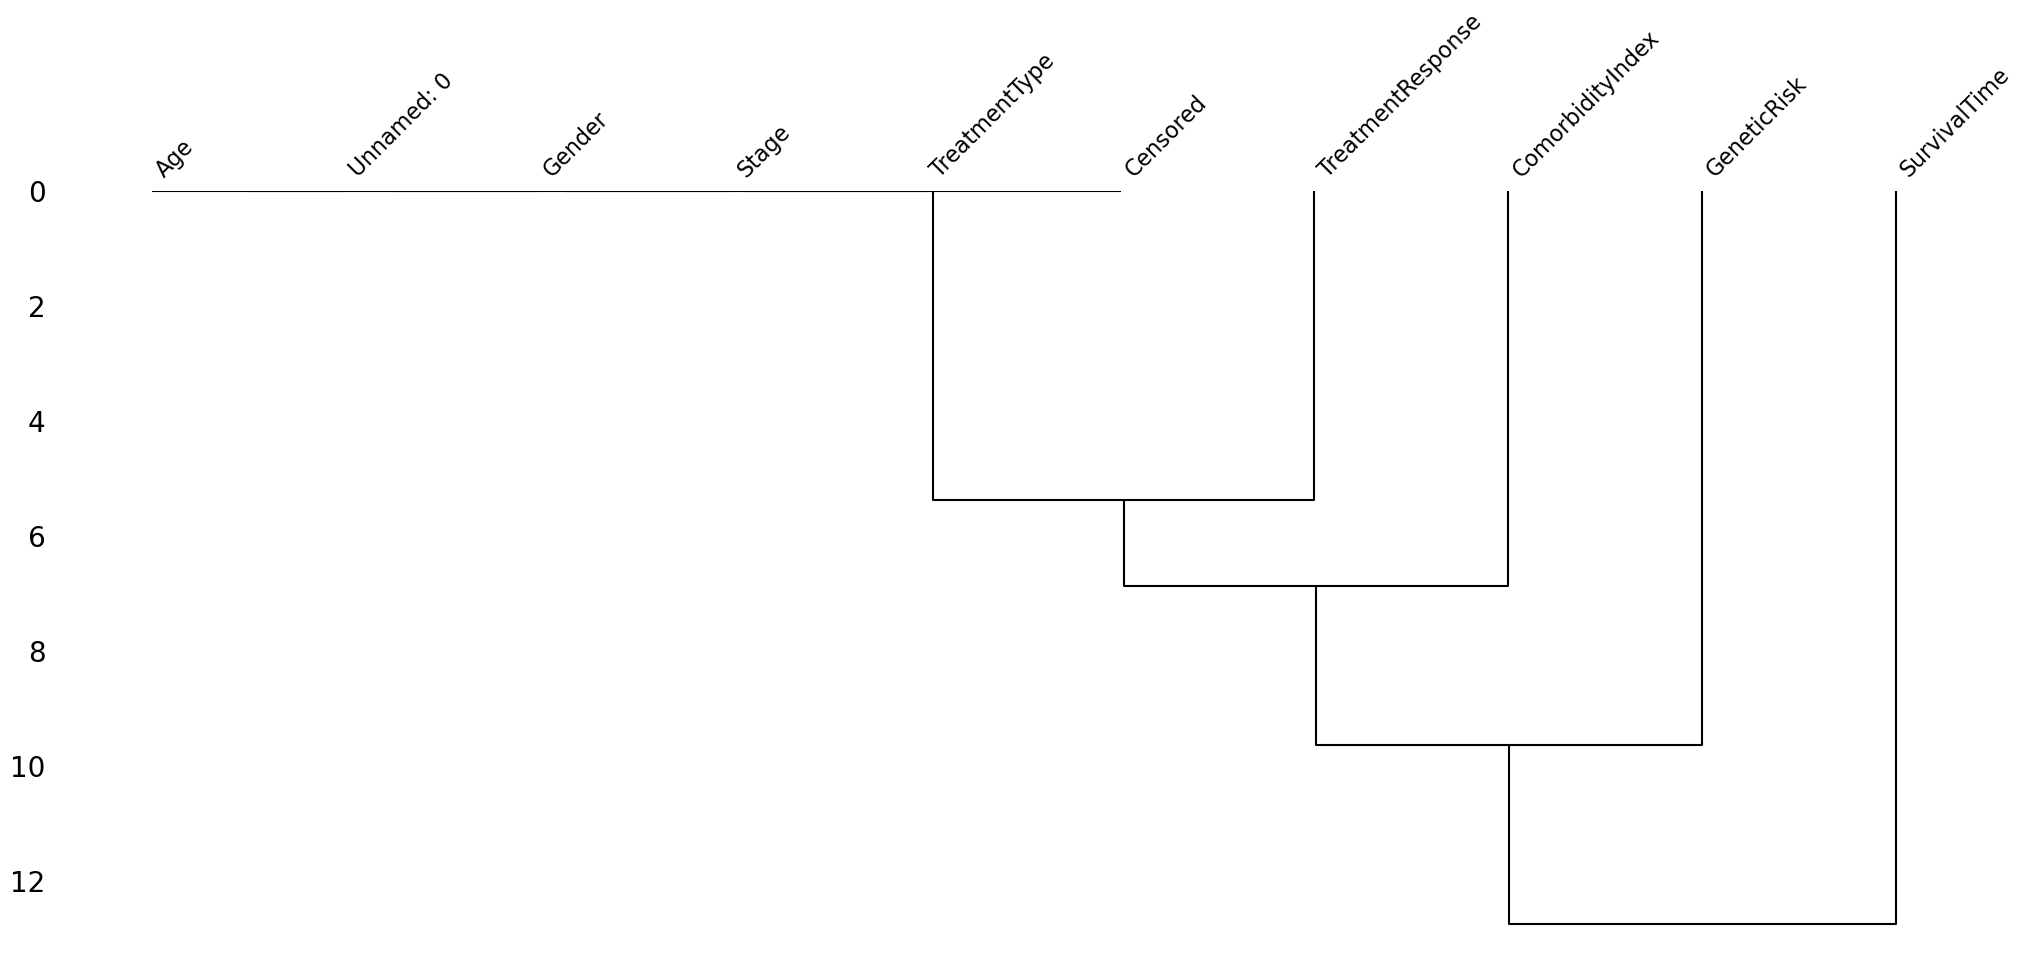

In [2]:
train = pd.read_csv("../data/train_data.csv")
test  = pd.read_csv("../data/test_data.csv")

msno.bar(train)
msno.heatmap(train)
msno.matrix(train)
msno.dendrogram(train)                                        

<h3> Dataset Analysis <h3>

In [3]:
#Initial dataset analysis
print("Initial Analysis of the training set:")
print(f"Total training examples: {len(train)}")
print(f"\nMissing values per column:")
print(train.isnull().sum())

print(f"\nCensored examples: {train['Censored'].sum()} ({100*train['Censored'].sum()/len(train):.1f}%)")
print(f"Non-Censored examples: {(train['Censored']==0).sum()} ({100*(train['Censored']==0).sum()/len(train):.1f}%)")

#Simulation: how many rows would remain if we dropped missing/censored rows
cols_with_missing = train.columns[train.isnull().any()]
print(f"\nColumns with missing values: {list(cols_with_missing)}")

#Count rows with any missing value in these columns
rows_with_missing = train[cols_with_missing].isnull().any(axis=1).sum()
print(f"Number of rows with any missing value: {rows_with_missing} ({100*rows_with_missing/len(train):.1f}%)")

#Count censored rows
censored_rows = train['Censored'].sum()
print(f"Number of censored rows: {censored_rows} ({100*censored_rows/len(train):.1f}%)")

#Count rows with missing SurvivalTime
missing_survival = train['SurvivalTime'].isnull().sum()
print(f"Number of rows with missing SurvivalTime: {missing_survival} ({100*missing_survival/len(train):.1f}%)")

#Estimate how many rows would remain if we dropped all missing + censored + missing SurvivalTime
rows_to_remove = train[cols_with_missing].isnull().any(axis=1) | (train['Censored']==1) | (train['SurvivalTime'].isnull())
remaining_rows = len(train) - rows_to_remove.sum()
print(f"\nEstimated rows remaining if dropping all missing + censored + missing SurvivalTime: {remaining_rows} ({100*remaining_rows/len(train):.1f}%)")

Initial Analysis of the training set:
Total training examples: 400

Missing values per column:
Unnamed: 0             0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64

Censored examples: 79 (19.8%)
Non-Censored examples: 321 (80.2%)

Columns with missing values: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse', 'SurvivalTime']
Number of rows with any missing value: 247 (61.8%)
Number of censored rows: 79 (19.8%)
Number of rows with missing SurvivalTime: 160 (40.0%)

Estimated rows remaining if dropping all missing + censored + missing SurvivalTime: 109 (27.2%)


<h3> Drop columns with missing data and rows as required <h3>

In [5]:
#Drop feature columns with missing values (but keep SurvivalTime) ---
feature_cols = train.columns.drop("SurvivalTime")  # exclude target
cols_with_missing = train[feature_cols].columns[train[feature_cols].isnull().any()]
train_dropped_cols = train.drop(columns=cols_with_missing)
print(f"Dropped feature columns with missing values: {list(cols_with_missing)}")
print(f"Remaining columns: {list(train_dropped_cols.columns)}")

#Drop rows with censored data ---
train_no_censored = train_dropped_cols[train_dropped_cols["Censored"] == 0]
print(f"Number of rows after dropping censored: {len(train_no_censored)}")

#Drop rows with missing SurvivalTime ---
train_final = train_no_censored.dropna(subset=["SurvivalTime"])
print(f"Number of rows after dropping missing SurvivalTime: {len(train_final)}")


Dropped feature columns with missing values: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse']
Remaining columns: ['Unnamed: 0', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']
Number of rows after dropping censored: 321
Number of rows after dropping missing SurvivalTime: 161


<h3> Pairplot between target (Survival Time) and Features <h3>

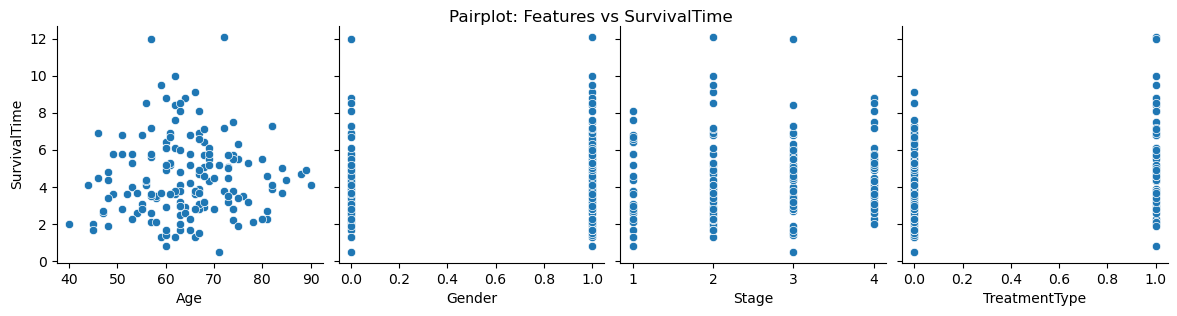

In [6]:
#Target and model features (features without missing values)
target = "SurvivalTime"
model_features = ["Age", "Gender", "Stage", "TreatmentType"]

#Create a DataFrame with only the features used in the model + target
df_model = train_final[model_features + [target]]

#Create pairplot: each feature vs the target
sns.pairplot(df_model, y_vars=[target], x_vars=model_features, kind="scatter", height=3)
plt.suptitle("Pairplot: Features vs SurvivalTime", y=1.02)
plt.show()

<h3> Matrix of X and vector of Y <h3>

In [7]:
#Creating the matrix and the vector 
X = train_final[model_features].values
y = train_final["SurvivalTime"].values  

<h3> Comparing Splitting Strategies <h3>

In [8]:
n_total = len(train_final)

#Train/Val/Test split (60/20/20)
train_size_1 = int(0.6 * n_total)
val_size_1 = int(0.2 * n_total)
test_size_1 = n_total - train_size_1 - val_size_1

print(f"Train/Val/Test (60/20/20):")
print(f"Train: {train_size_1} exemples")
print(f"Val: {val_size_1} exemples")
print(f"Test: {test_size_1} exemples")

#Train/Test + 5-Fold CV
train_size_2 = int(0.8 * n_total)
test_size_2 = n_total - train_size_2

print(f"Train/Test (80/20) + 5-Fold CV:")
print(f"Train: {train_size_2} exemplos")
print(f"Test: {test_size_2} exemplos")
print(f"Each fold in train in CV: ~{int(0.8 * train_size_2)} exemples")
print(f"Each fold in validation in CV: ~{int(0.2 * train_size_2)} exemples")

Train/Val/Test (60/20/20):
Train: 96 exemples
Val: 32 exemples
Test: 33 exemples
Train/Test (80/20) + 5-Fold CV:
Train: 128 exemplos
Test: 33 exemplos
Each fold in train in CV: ~102 exemples
Each fold in validation in CV: ~25 exemples


<h3> Defining new metric cMSE <h3>

In [9]:
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

<h2> Task 1.2 - Learn the baseline model <h2>

Train size: 128
Test size: 33
Cross-validated MSE: 4.522611663066811
Final Test MSE: 4.411178530294957


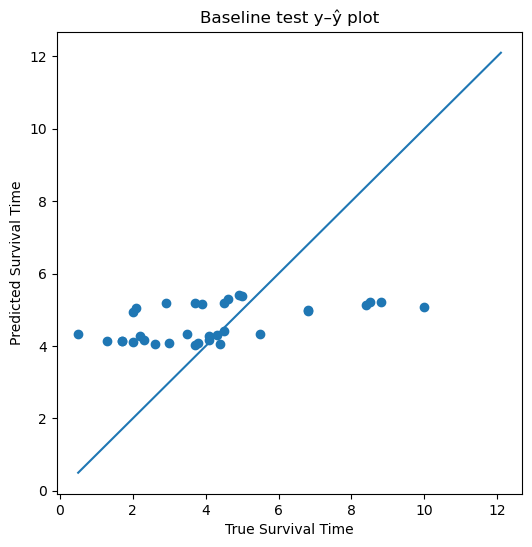

In [11]:
#Splitting the dataset for Cross Validation
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X,
    y,
    train_final["Censored"].values,  # inclui censura aqui
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

#Baseline model with Linear Regression and Standard Scaler
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

#Cross-validation to evaluate the baseline model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_hat_cv = cross_val_predict(baseline, X_train, y_train, cv=cv)

mse_cv =mean_squared_error(y_train, y_hat_cv)
print("Cross-validated MSE:", mse_cv)

#Fitting the baseline model
baseline.fit(X_train, y_train)
y_test_hat = baseline.predict(X_test)

#Using MSE as error metric beacause for data with c=0 MSE=cMSE
mse_test = mean_squared_error(y_test, y_test_hat)
print("Final Test MSE:", mse_test)

#Y_y_hat plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_hat)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline test y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

<h3> Kaggle submission <h3>

In [12]:
#Retraining the baseline on the entire train_final dataset
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(train_final[model_features].values, train_final["SurvivalTime"].values)

#Verifying missing values in the test set for the model features
print(test[model_features].isnull().sum())

#Prevision in test set
test_pred = baseline.predict(test[model_features])

#Create submission in the format of sample_submission.csv (id, 0)
sub = pd.DataFrame({
    "id": test["id"],
    "0": test_pred
})

sub.to_csv("baseline-submission-01.csv", index=False)
print("Submission saved as baseline-submission-01.csv")


Age              0
Gender           0
Stage            0
TreatmentType    0
dtype: int64
Submission saved as baseline-submission-01.csv


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<h1> Task 2 - Nonlinear models <h2>

<h2> Tssk 2.1 - Development <h2>

<h3> Polynomial Model <h3>

In [14]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  # If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array)  # The model is a linear regression with Ridge
    else:
        regressor = LinearRegression()  # If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def train_polynomial_cv(
    X_train, y_train,  #Split data from the make_train_val_test_split function
    degrees=range(1, 8),
    cv=5, 
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)):
    
    #Cross-validation setup
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {
        'degrees': [],
        'n_features': [],
        'mse_train': [],
        'mse_cv': []}
    
    #Training for each degree
    for degree in degrees:
        #Create pipeline with StandardScaler, PolynomialFeatures, and chosen regressor
        regr = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
        model = make_pipeline(
            StandardScaler(with_mean=True),
            PolynomialFeatures(degree=degree, include_bias=False),
            regr)
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()

        #Train on full training set to get training error
        model.fit(X_train, y_train)
        n_features = model.named_steps['polynomialfeatures'].n_output_features_
        
        #Store results
        results['degrees'].append(degree)
        results['n_features'].append(n_features)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        print(f"Degree {degree}:"
              f"Number features = {n_features}, "
              f"Train MSE = {mse_train:.2f}, "
              f"CV MSE = {mse_cv:.2f}")
    
    #Select best degree (lowest CV MSE)
    best_idx = np.argmin(results['mse_cv'])
    best_degree = results['degrees'][best_idx]
    best_cv_mse = results['mse_cv'][best_idx]
    
    print(f"BEST POLYNOMIAL DEGREE: {best_degree} (CV MSE = {best_cv_mse:.2f})")

    # Train final model with best degree - FIXED
    regr_final = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        PolynomialFeatures(degree=best_degree, include_bias=False),
        regr_final)

    best_model.fit(X_train, y_train)
    
    return best_model, results

#Polynomial Regression without Ridge regularization
print("Polynomial Regression Without Ridge Regularization")

poly_model_linear, poly_results_linear = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=False, 
    random_state=42)

#Polynomial Regression without Ridge regularization
print("Polynomial Regression With Ridge Regularization")

poly_model_ridge, poly_results_ridge = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=True, 
    ridge_alphas=(0.1, 1.0, 10.0, 100.0, 1000.0),  
    random_state=42)



Polynomial Regression Without Ridge Regularization
Degree 1:Number features = 4, Train MSE = 4.03, CV MSE = 4.53
Degree 2:Number features = 14, Train MSE = 3.64, CV MSE = 5.02
Degree 3:Number features = 34, Train MSE = 3.00, CV MSE = 9.35
Degree 4:Number features = 69, Train MSE = 2.27, CV MSE = 16.19
Degree 5:Number features = 125, Train MSE = 1.52, CV MSE = 344.36
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.53)
Polynomial Regression With Ridge Regularization
Degree 1:Number features = 4, Train MSE = 4.14, CV MSE = 4.42
Degree 2:Number features = 14, Train MSE = 3.98, CV MSE = 4.50
Degree 3:Number features = 34, Train MSE = 3.90, CV MSE = 4.51
Degree 4:Number features = 69, Train MSE = 3.79, CV MSE = 4.41
Degree 5:Number features = 125, Train MSE = 3.53, CV MSE = 4.59
BEST POLYNOMIAL DEGREE: 4 (CV MSE = 4.41)


<h3> KNN Model <h3>

In [15]:
#k-Nearest Neighbors regression with Cross-Validation to choose the best k
def train_knn_cv(X_train, y_train, k_values=range(1, 30), cv=5, random_state=42):
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {'k_values': [], 'mse_train': [], 'mse_cv': [], 'std_cv': []}
    
    print("k-Nearest Neighbors:")
    
    #Training for each k
    for k in k_values:
        model = make_pipeline(
            StandardScaler(with_mean=True),
            KNeighborsRegressor(n_neighbors=k))
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()
        
        model.fit(X_train, y_train)
        
        results['k_values'].append(k)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        if k <= 10 or k % 5 == 0:
            print(f"k={k:2d}: Train MSE={mse_train:.2f}, CV MSE={mse_cv:.2f}")
    
    best_idx = np.argmin(results['mse_cv'])
    best_k = results['k_values'][best_idx]
    print(f"\nBEST k: {best_k} (CV MSE = {results['mse_cv'][best_idx]:.2f})")
    
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X_train, y_train)
    
    return best_model, results

knn_model, knn_results = train_knn_cv(
        X_train, y_train,
        k_values=range(1, 30), 
        cv=5,
        random_state=42)

k-Nearest Neighbors:
k= 1: Train MSE=0.97, CV MSE=8.62
k= 2: Train MSE=1.76, CV MSE=6.43
k= 3: Train MSE=2.54, CV MSE=5.46
k= 4: Train MSE=3.03, CV MSE=5.11
k= 5: Train MSE=3.34, CV MSE=5.15
k= 6: Train MSE=3.52, CV MSE=4.91
k= 7: Train MSE=3.54, CV MSE=4.73
k= 8: Train MSE=3.51, CV MSE=4.51
k= 9: Train MSE=3.47, CV MSE=4.46
k=10: Train MSE=3.51, CV MSE=4.41
k=15: Train MSE=3.80, CV MSE=4.54
k=20: Train MSE=3.95, CV MSE=4.48
k=25: Train MSE=4.04, CV MSE=4.47

BEST k: 28 (CV MSE = 4.41)


<h2> Task 2.2 - Evaluation <h2>

                       Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
Baseline (Linear Regression)   4.081195 4.522612  4.411179    2.020197 2.126643   2.100281
 Polynomial Ridge (Degree 4)   3.833154 4.409394  4.873485    1.957844 2.099856   2.207597
                 k-NN (k=28)   4.061169 4.402903  4.387807    2.015234 2.098310   2.094709
Ranking of Models Based on Test MSE:
 Rank                        Model  Test_MSE  Test_RMSE   CV_MSE
    1                  k-NN (k=28)  4.387807   2.094709 4.402903
    2 Baseline (Linear Regression)  4.411179   2.100281 4.522612
    3  Polynomial Ridge (Degree 4)  4.873485   2.207597 4.409394
Best Model: k-NN (k=28)
Test MSE: 4.3878
Test RMSE: 2.0947


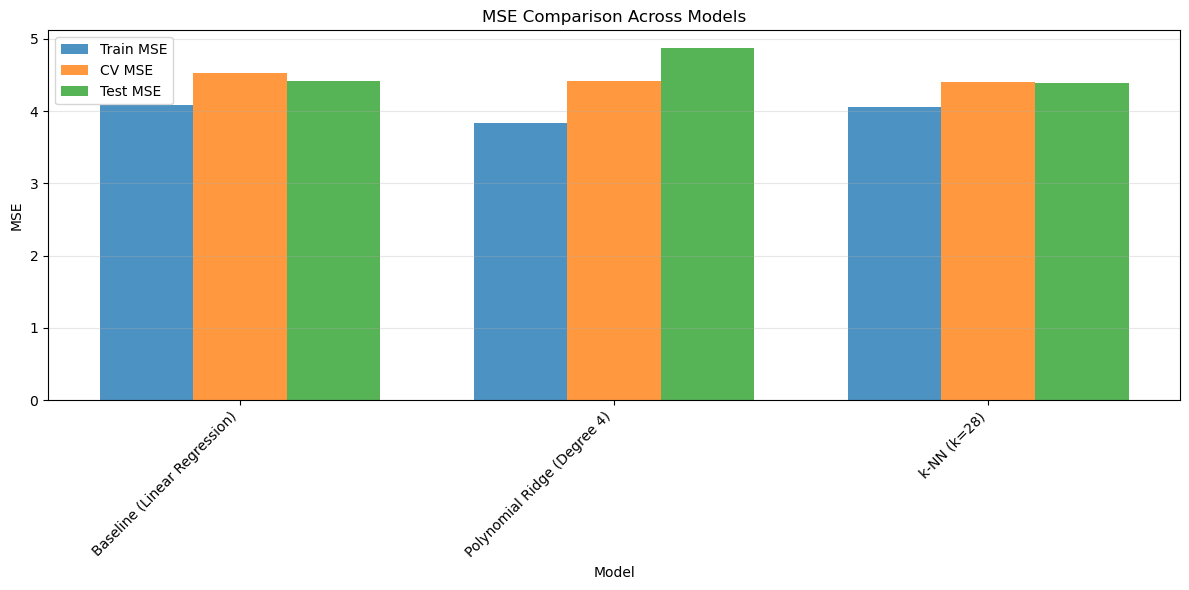

In [16]:
#Comprehensive evaluation function
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, 
                                 model_name, cv=5, random_state=42):

    #Cross-validation predictions on training set
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
    
    #Train set predictions (refit on full training set)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    #Test set predictions
    y_test_pred = model.predict(X_test)
    
    #Calculate errors
    train_errors = y_train - y_train_pred
    cv_errors = y_train - y_train_pred_cv
    test_errors = y_test - y_test_pred
    
    #Compile results
    results = {
        'Model': model_name,
        
        # Training and Cross-Validation Metrics
        'Train_MSE': mean_squared_error(y_train, y_train_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MSE': mean_squared_error(y_train, y_train_pred_cv),
        'CV_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_cv)),
        
        # Test Set Metrics
        'Test_MSE': mean_squared_error(y_test, y_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
        
    return results

#Function to compare multiple models
def compare_models(models_dict, X_train, y_train, X_test, y_test, cv=5, random_state=42):
    
    all_results = []

    for model_name, model in models_dict.items():
        results = evaluate_model_comprehensive(
            model, X_train, y_train, X_test, y_test, 
            model_name, cv, random_state)
        all_results.append(results)
    
    #Create comprehensive DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() 
                                if k not in ['y_test_pred', 'test_errors']} 
                               for r in all_results])
    
    return results_df, all_results

def print_comparison_tables(results_df):

    #Main metrics table
    main_metrics = results_df[['Model', 'Train_MSE', 'CV_MSE', 'Test_MSE', 
                                'Train_RMSE', 'CV_RMSE', 'Test_RMSE']].copy()
    print(main_metrics.to_string(index=False))
    
    print("Ranking of Models Based on Test MSE:")
    #Ranking
    ranking = results_df[['Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']].copy()
    ranking = ranking.sort_values('Test_MSE')
    ranking['Rank'] = range(1, len(ranking) + 1)
    ranking = ranking[['Rank', 'Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']]
    print(ranking.to_string(index=False))
    
    #Print best model
    best_model = ranking.iloc[0]
    print(f"Best Model: {best_model['Model']}")
    print(f"Test MSE: {best_model['Test_MSE']:.4f}")
    print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")    
    return ranking

#Function to plot model comparison with MSE values
def plot_model_comparison(results_df, all_results, y_test):
    
    n_models = len(results_df)
    x_pos = np.arange(n_models)
    width = 0.25
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos - width, results_df['Train_MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x_pos, results_df['CV_MSE'], width, label='CV MSE', alpha=0.8)
    plt.bar(x_pos + width, results_df['Test_MSE'], width, label='Test MSE', alpha=0.8)
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.title('MSE Comparison Across Models')
    plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

best_degree_ridge = poly_results_ridge['degrees'][np.argmin(poly_results_ridge['mse_cv'])]
best_k = knn_results['k_values'][np.argmin(knn_results['mse_cv'])]

models_dict = {
    "Baseline (Linear Regression)": baseline,
    f"Polynomial Ridge (Degree {best_degree_ridge})": poly_model_ridge,
    f"k-NN (k={best_k})": knn_model,
}

#Comprehensive comparison
results_df, all_results = compare_models(
    models_dict, X_train, y_train, X_test, y_test, 
    cv=5, random_state=42)
    
#rint comparison tables
ranking = print_comparison_tables(results_df)
    
#Create plot
plot_model_comparison (results_df, all_results, y_test)

<h3> Kaggle submission <h3>


Best model for Task 2: k-NN (k=28)


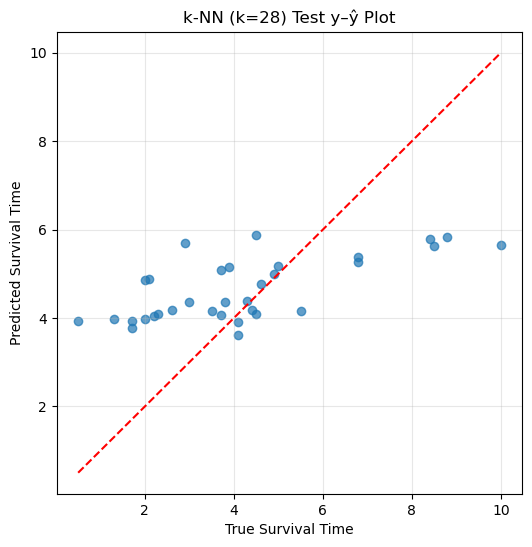

k-NN (k=28) Test MSE: 3.7152
Nonlinear submission saved to ../outputs/csv/Nonlinear-submission-01.csv


In [17]:
#Select the best model according to Test_MSE from the comparison table (lower Test_MSE is better)
best_row = results_df.sort_values("Test_MSE").iloc[0]
best_model_name = best_row["Model"]
print(f"\nBest model for Task 2: {best_model_name}")

#Retrieve the corresponding model object from models_dict
best_model = models_dict[best_model_name]

#Train the best model on the full training data using the same model_features
X_full = train_final[model_features].values
y_full = train_final["SurvivalTime"].values

best_model.fit(X_full, y_full)

y_test_pred_nonlinear = best_model.predict(X_test)

#Y–ŷ plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_nonlinear, alpha=0.7)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title(f"{best_model_name} Test y–ŷ Plot")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True, alpha=0.3)
plt.show()

#MSE local
mse_test_nonlinear = mean_squared_error(y_test, y_test_pred_nonlinear)
print(f"{best_model_name} Test MSE: {mse_test_nonlinear:.4f}")


#Prepare the test features (must use the same model_features)
X_test_full = test[model_features].values

#Predict survival time for the test set
test_pred_nonlinear = best_model.predict(X_test_full)

#Ensure the output directory exists (relative to the notebook path)
os.makedirs("../outputs/csv", exist_ok=True)

#Build the submission DataFrame in Kaggle format (columns: id, 0)
sub_nonlinear = pd.DataFrame({
    "id": test["id"],   # id column from test_data.csv
    "0": test_pred_nonlinear  # predicted SurvivalTime
})

#Save the submission file for Task 2
output_path = "../outputs/csv/Nonlinear-submission-01.csv"
sub_nonlinear.to_csv(output_path, index=False)

print(f"Nonlinear submission saved to {output_path}")


<h1> Task 3 - Handling missing data </h1>
<h2> Task 3.1 - Missing data imputation </h2>

Train size (with missing features allowed): 161
Missing values per feature:
Age                   0
Gender                0
Stage                 0
GeneticRisk          27
TreatmentType         0
ComorbidityIndex     18
TreatmentResponse    11
dtype: int64
Train size: 128
Test size: 33
     Strategy   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE  Test_Error_Mean  Test_Error_Std  Test_Error_Min  Test_Error_Max
         mean 3.724064 1.929783  3.385637   1.840010        -0.378024        1.800759       -3.330081        4.089464
        knn_5 3.691390 1.921299  3.411269   1.846962        -0.378680        1.807725       -3.317624        4.184869
       median 3.740975 1.934160  3.499507   1.870697        -0.354914        1.836721       -3.308380        4.302358
most_frequent 3.740975 1.934160  3.499507   1.870697        -0.354914        1.836721       -3.308380        4.302358
constant_zero 3.765090 1.940384  3.541510   1.881890        -0.410013        1.836682       -3.395324        4.048022

Best

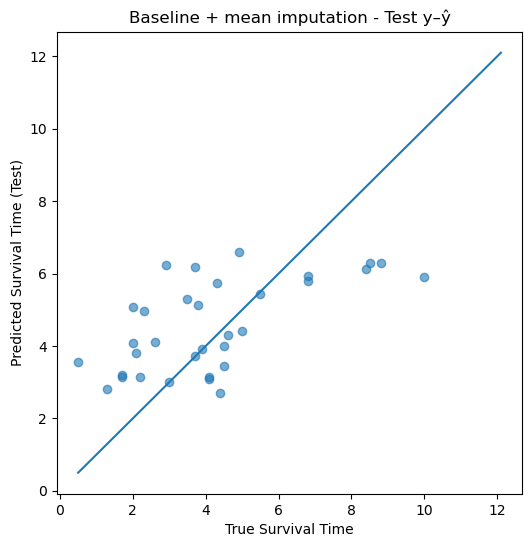

In [21]:
#Build supervised dataset including rows with missing features
#We now include rows that may have missing feature values.
#We still restrict to uncensored patients (Censored == 0) and require SurvivalTime to be observed (no missing target).
full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse",
]

supervised_mask = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_imp = train.loc[supervised_mask].copy()

print("Train size (with missing features allowed):", len(train_imp))
print("Missing values per feature:")
print(train_imp[full_feature_cols].isnull().sum())

X_imp = train_imp[full_feature_cols].values
y_imp = train_imp["SurvivalTime"].values

#Train/test split for evaluation (similar to Task 1.2 but now with missing features)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train_imp))
print("Test size:", len(X_test_imp))

#Imputation strategies + baseline model (Linear Regression)
# Define different imputation strategies to try with the baseline model
imputation_strategies = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median"),
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "constant_zero": SimpleImputer(strategy="constant", fill_value=0.0),
    "knn_5": KNNImputer(n_neighbors=5, weights="uniform"),
}

def evaluate_baseline_with_imputer(imputer_name, imputer, 
                                   X_train, y_train, X_test, y_test,
                                   cv_splits=5, random_state=42):

    #Build pipeline
    model = make_pipeline(
        imputer,
        StandardScaler(with_mean=True),
        LinearRegression()
    )
    
    #Cross-validation on training data
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    cv_mse = mean_squared_error(y_train, y_train_pred_cv)
    cv_rmse = np.sqrt(cv_mse)
    
    #Fit on training set and evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    #Error statistics (for slides)
    test_errors = y_test - y_test_pred
    stats = {
        "Strategy": imputer_name,
        "CV_MSE": cv_mse,
        "CV_RMSE": cv_rmse,
        "Test_MSE": test_mse,
        "Test_RMSE": test_rmse,
        "Test_Error_Mean": np.mean(test_errors),
        "Test_Error_Std": np.std(test_errors),
        "Test_Error_Min": np.min(test_errors),
        "Test_Error_Max": np.max(test_errors),
        "model": model,  # keep fitted model in case this is the best
        "y_test_pred": y_test_pred,
        "y_train_pred_cv": y_train_pred_cv,
    }
    return stats

#Run all strategies and collect results
imputation_results = []
for name, imp in imputation_strategies.items():
    stats = evaluate_baseline_with_imputer(
        name, imp,
        X_train_imp, y_train_imp,
        X_test_imp, y_test_imp,
        cv_splits=5,
        random_state=42
    )
    imputation_results.append(stats)

#Build a DataFrame with the results (for tables in slides)
imp_results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ["model", "y_test_pred", "y_train_pred_cv"]}
    for d in imputation_results
])

print(imp_results_df.sort_values("Test_MSE").to_string(index=False))

#Pick the best imputation strategy (based on CV or Test MSE)
# Here we choose based on Test_MSE (you can justify in slides)
best_row_imp = imp_results_df.sort_values("Test_MSE").iloc[0]
best_strategy_name = best_row_imp["Strategy"]
print(f"\nBest imputation strategy for baseline: {best_strategy_name}")

# Retrieve the corresponding full stats (including model and predictions)
best_stats_full = next(d for d in imputation_results if d["Strategy"] == best_strategy_name)
baseline_imputed_best = best_stats_full["model"]
y_train_cv_best = best_stats_full["y_train_pred_cv"]
y_test_pred_best = best_stats_full["y_test_pred"]

# y–ŷ plots for the best imputation strategy (baseline)
min_y, max_y = y_imp.min(), y_imp.max()
plt.figure(figsize=(6, 6))
plt.scatter(y_test_imp, y_test_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Test)")
plt.title(f"Baseline + {best_strategy_name} imputation - Test y–ŷ")
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

<h3> Task 3.1 - Applying best imputation to nonlinear models </h3>


Models with best imputation strategy
                    Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
          Baseline + mean   3.035999    1.742412 3.724064 1.929783  3.385637    1.84001
Poly Ridge (deg=4) + mean   2.437594    1.561279 3.997635 1.999409  4.503987    2.12226
       k-NN (k=28) + mean   3.329257    1.824625 3.654399 1.911648  3.928006    1.98192


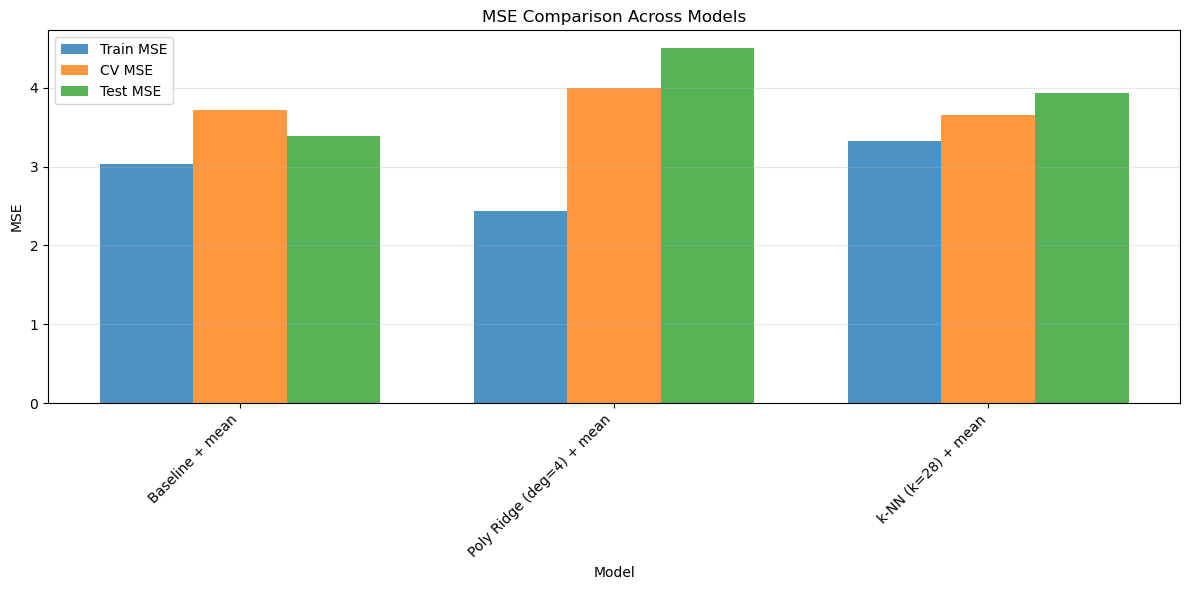

In [ ]:

#Rebuild an unfitted imputer corresponding to best_strategy_name (so we do not reuse the already-fitted one from before)
if best_strategy_name == "mean":
    best_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    best_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    best_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    best_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    best_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

#We reuse the best hyperparameters found in Task 2: best_degree_ridge (for Polynomial Ridge) and best_k (for k-NN)
#They should already be defined from Task 2.
#Polynomial Ridge with imputation
poly_ridge_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    PolynomialFeatures(degree=best_degree_ridge, include_bias=False),
    RidgeCV(alphas=np.array([0.1, 1.0, 10.0, 100.0, 1000.0]))
)

#k-NN with imputation
knn_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k)
)

#Baseline with the best imputer (for comparison in this task)
baseline_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

#Compare the three models on the Task 3.1 dataset (with missing features)
models_task3 = {
    f"Baseline + {best_strategy_name}": baseline_imputed,
    f"Poly Ridge (deg={best_degree_ridge}) + {best_strategy_name}": poly_ridge_imputed,
    f"k-NN (k={best_k}) + {best_strategy_name}": knn_imputed,
}

results_task3_df, _ = compare_models(
    models_task3,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\nModels with best imputation strategy")
print(results_task3_df.to_string(index=False))

# Optional: plot comparison of MSE across models in Task 3.1
plot_model_comparison(results_task3_df, _, y_test_imp)

<h2> Task 3.2 - Models that do not require imputation </h2>

In [23]:
import sys
print(sys.executable)

import sys
!{sys.executable} -m pip install catboost


from catboost import CatBoostRegressor, Pool
print("CatBoost import OK")

/opt/anaconda3/bin/python
CatBoost import OK


                                        Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
                      Baseline + mean imputer   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
HistGradientBoostingRegressor (no imputation)   1.599550    1.264733 4.582118 2.140588  4.045936   2.011451


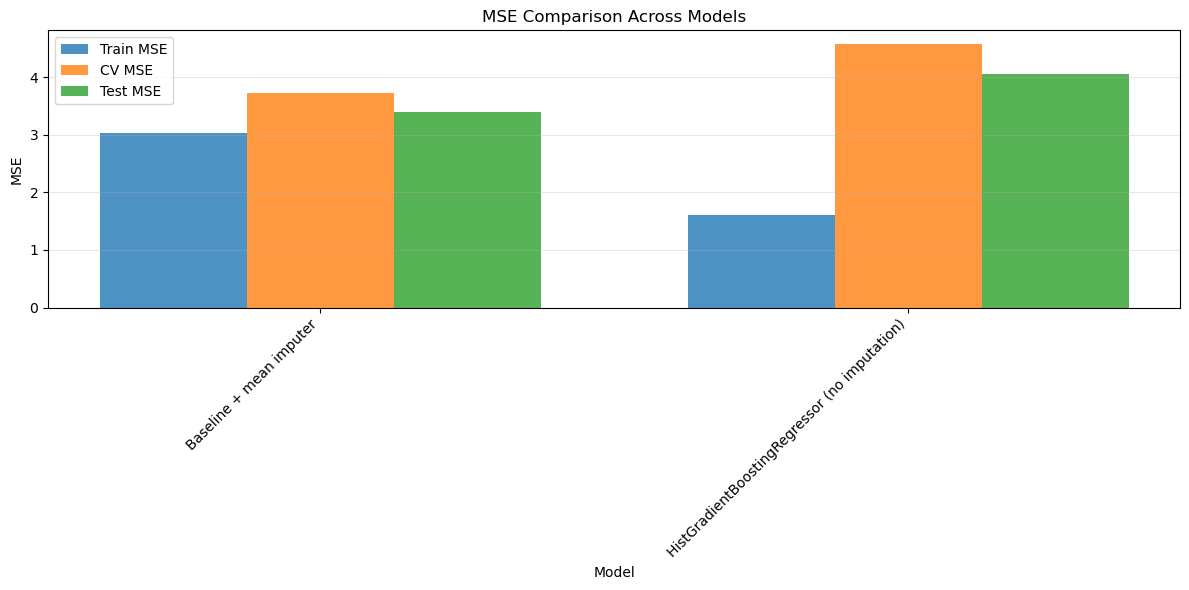

In [25]:
#Baseline with best imputation strategy (for comparison)
#We rebuild the baseline pipeline using the best_imputer found in Task 3.1.
baseline_imputed_t32 = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

#HistGradientBoostingRegressor
#This model natively supports missing values (NaN) in the features.
#We do NOT impute anything here, we pass X with NaN directly.
hgb_model = HistGradientBoostingRegressor(
    max_iter=400,
    learning_rate=0.05,
    max_depth=None,
    l2_regularization=0.0,
    random_state=42
)

#We will compare: Baseline + best imputation (from Task 3.1) and HistGradientBoostingRegressor (no imputation; uses raw X with NaN)
models_task32 = {
    f"Baseline + {best_strategy_name} imputer": baseline_imputed_t32,
    "HistGradientBoostingRegressor (no imputation)": hgb_model,
}

#Note: we evaluate on the Task 3.1 supervised dataset (train_imp), which includes missing feature values.
results_task32_df, _ = compare_models(
    models_task32,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)
print(results_task32_df.to_string(index=False))

#Plot MSE comparison for slides
plot_model_comparison(results_task32_df, _, y_test_imp)


In [26]:

import catboost
print(catboost.__version__)


1.2.8


In [28]:
full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
]

#Using all patients 
aft_mask = train["SurvivalTime"].notna()
train_aft = train.loc[aft_mask].copy()

X_aft = train_aft[full_feature_cols].values
time_aft = train_aft["SurvivalTime"].values
cens_aft = train_aft["Censored"].values 

def make_aft_labels(time, censored):
    lower = time
    upper = np.where(censored == 1, np.inf, time)
    return np.vstack([lower, upper]).T

y_aft = make_aft_labels(time_aft, cens_aft)

#Train/validation split
X_train, X_val, y_train, y_val, cens_train, cens_val = train_test_split(
    X_aft, y_aft, cens_aft, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)

# Modelo AFT
aft_model = CatBoostRegressor(
    loss_function="SurvivalAft:dist=Normal",  
    eval_metric="SurvivalAft",
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=False
)

aft_model.fit(train_pool, eval_set=val_pool)

#Predictions
y_pred_log = aft_model.predict(val_pool)
y_pred = np.exp(y_pred_log)

#cMSE
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

time_val = y_val[:, 0]   # limite inferior
cMSE_val = error_metric(time_val, y_pred, cens_val)

print("CatBoost AFT - validation cMSE:", cMSE_val)
print("Number of validation samples:", len(time_val))

Got unsafe target value = inf at object #6 of dataset learn
Got unsafe target value = inf at object #2 of dataset test #0


CatBoost AFT - validation cMSE: 3.0603373045665756
Number of validation samples: 48


<h2> Task 3.3 -  Evaluation </h2>

                                        Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
                              Baseline + mean   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
                      Baseline + mean imputer   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
          HistGradientBoosting + best imputer   1.736459    1.317748 4.493745 2.119846  3.922908   1.980633
                           k-NN (k=28) + mean   3.329257    1.824625 3.654399 1.911648  3.928006   1.981920
                      CatBoost + best imputer   0.026619    0.163155 4.868306 2.206424  3.988760   1.997188
HistGradientBoostingRegressor (no imputation)   1.599550    1.264733 4.582118 2.140588  4.045936   2.011451
                    Poly Ridge (deg=4) + mean   2.437594    1.561279 3.997635 1.999409  4.503987   2.122260


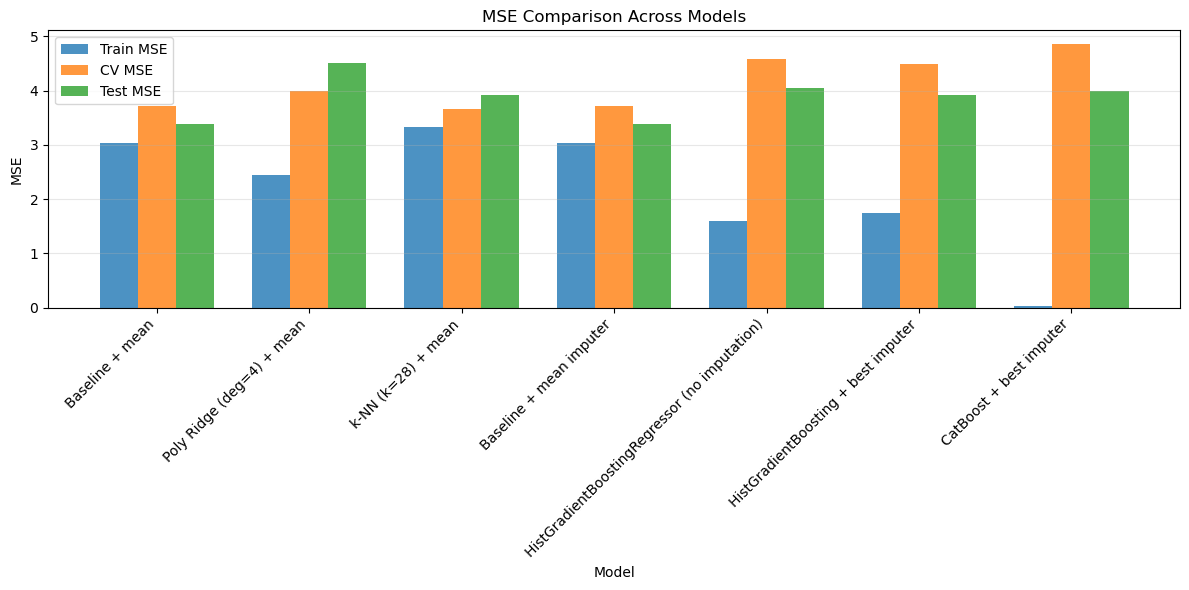


Best overall model in Task 3: Baseline + mean
Test MSE:  3.3856
Test RMSE: 1.8400


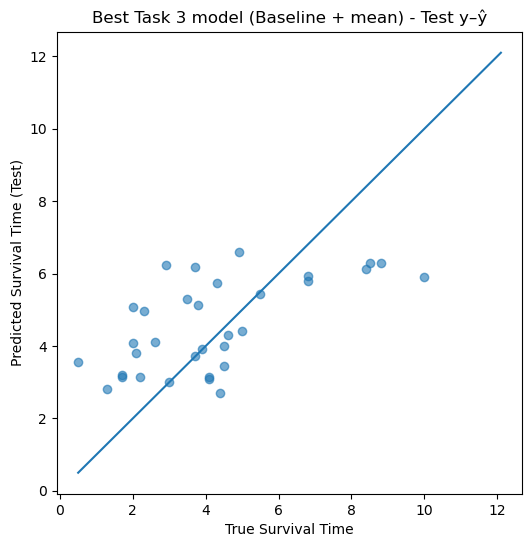


Task 3 submission saved to ../outputs/csv/handle-missing-submission-01.csv
Best model used: Baseline + mean
Use this file on Kaggle as: handle-missing-submission-01.csv


In [33]:
#Combine models from Task 3.1 and Task 3.2 in one comparison
all_models_task3 = {}
all_models_task3.update(models_task3)
all_models_task3.update(models_task32)

#HistGradientBoosting WITH imputation (same best_imputer)
hgb_imputed = make_pipeline(
    best_imputer,
    HistGradientBoostingRegressor(
        max_iter=400,
        learning_rate=0.05,
        max_depth=None,
        l2_regularization=0.0,
        random_state=42
    )
)
all_models_task3["HistGradientBoosting + best imputer"] = hgb_imputed

#CatBoost WITH imputation
catboost_imputed_pipe = make_pipeline(
    best_imputer,
    CatBoostRegressor(
        loss_function="RMSE",  # Changed from SurvivalAft
        eval_metric="RMSE",     # Changed from SurvivalAft
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=42,
        verbose=False
    )
)
all_models_task3["CatBoost + best imputer"] = catboost_imputed_pipe

#Compare all models
results_task33_df, all_results_task33 = compare_models(
    all_models_task3,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print(results_task33_df.sort_values("Test_MSE").to_string(index=False))

# Plot comparison of Train / CV / Test MSE
plot_model_comparison(results_task33_df, all_results_task33, y_test_imp)

#Pick the overall best model 
best_row_task3 = results_task33_df.sort_values("Test_MSE").iloc[0]
best_task3_name = best_row_task3["Model"]
print(f"\nBest overall model in Task 3: {best_task3_name}")
print(f"Test MSE:  {best_row_task3['Test_MSE']:.4f}")
print(f"Test RMSE: {best_row_task3['Test_RMSE']:.4f}")

best_task3_model = all_models_task3[best_task3_name]

#y–ŷ plot for the BEST model
best_task3_model.fit(X_train_imp, y_train_imp)
y_train_pred_best = best_task3_model.predict(X_train_imp)
y_test_pred_best  = best_task3_model.predict(X_test_imp)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_imp, y_test_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Test)")
plt.title(f"Best Task 3 model ({best_task3_name}) - Test y–ŷ")
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

#Use the best performing model for submission (not forcing AFT)
submission_model = best_task3_model

#Refit the model on the complete dataset (only supervised examples)
X_all_imp = train_imp[full_feature_cols].values
y_all_imp = train_imp["SurvivalTime"].values

submission_model.fit(X_all_imp, y_all_imp)

#Predict on test set
X_test_full_imp = test[full_feature_cols].values
test_pred_task3 = submission_model.predict(X_test_full_imp)

#Ensure output directory exists
os.makedirs("../outputs/csv", exist_ok=True)

#Build submission DataFrame
sub_task3 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_task3
})

submission_path_t3 = "../outputs/csv/handle-missing-submission-01.csv"
sub_task3.to_csv(submission_path_t3, index=False)

print(f"\nTask 3 submission saved to {submission_path_t3}")
print(f"Best model used: {best_task3_name}")
print("Use this file on Kaggle as: handle-missing-submission-01.csv")

<h1> Task 4 - Semi-supervised learning for unlabeled data <h1>

<h2> Task 4.1 - Imputation with labeled and unlabeled data </h2>


==================== Task 4.1 - Imputation with labelled + unlabelled ====================

Total rows (labelled + unlabelled): 400
Labelled rows (for regression):     161
Unlabelled rows:                    239

Labelled train size (Task 4.1): 128
Labelled test size   (Task 4.1): 33

--- Task 4.1 – Semi-supervised Linear Regression ---
Train_MSE: 3.0350
Train_RMSE: 1.7421
CV_MSE: 3.7301
CV_RMSE: 1.9314
Test_MSE: 3.3866
Test_RMSE: 1.8403


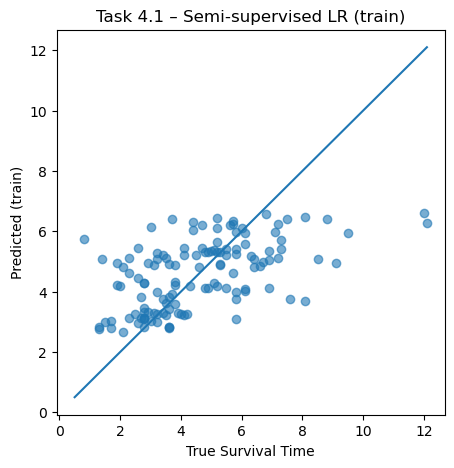

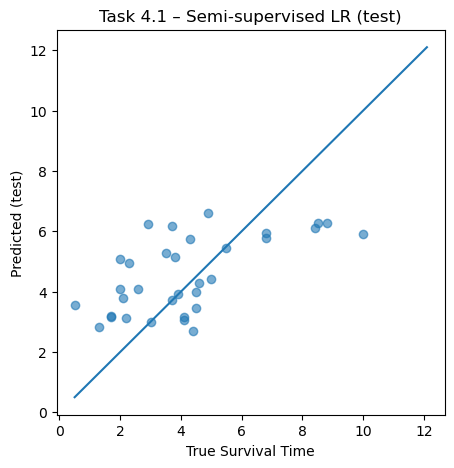


--- Training Isomap with n_components = 2 on ALL data ---

--- Training Isomap with n_components = 3 on ALL data ---

--- Training Isomap with n_components = 5 on ALL data ---

=== Task 4.1 – Semi-supervised Isomap + LR results ===
                            Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
Semi-supervised Isomap (n_comp=2)   3.950308    1.987538 4.195860 2.048380  4.419078   2.102160
Semi-supervised Isomap (n_comp=3)   3.603134    1.898192 3.902032 1.975356  3.986302   1.996573
Semi-supervised Isomap (n_comp=5)   3.450901    1.857660 3.858672 1.964350  4.406769   2.099230

Best semi-supervised Isomap model: n_components = 3
Test MSE:  3.9863
Test RMSE: 1.9966

=== Task 4.1 – Final comparison (semi-supervised models) ===
                Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
          Semi-sup LR   3.034985    1.742121 3.730131 1.931355  3.386638   1.840282
Semi-sup Isomap (n=3)   3.603134    1.898192 3.902032 1.975356  

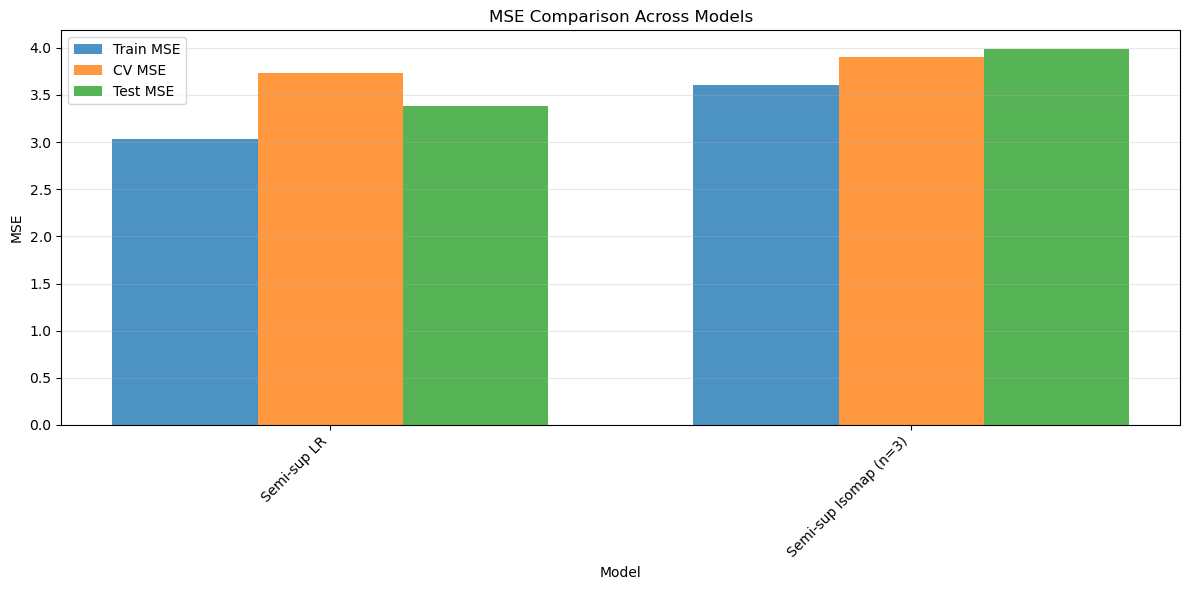

In [ ]:
# Task 4.1 - Semi-supervised
# ============================

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import Isomap
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline

print("\n==================== Task 4.1 - Imputation with labelled + unlabelled ====================\n")

# ------------------------------------------------------------------
# 1) Rebuild the best IMPUTER from Task 3.1 (but UNFITTED)
# ------------------------------------------------------------------
if best_strategy_name == "mean":
    semi_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    semi_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    semi_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    semi_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    semi_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

# ------------------------------------------------------------------
# 2) Build LABELLED and UNLABELLED sets
#    - labelled = SurvivalTime not NaN AND Censored == 0
#    - unlabelled = all other rows
# ------------------------------------------------------------------
label_mask = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
unlabel_mask = ~label_mask

X_all_raw = train[full_feature_cols].values         # ALL patients
y_all = train["SurvivalTime"].values               # has NaNs for unlabeled
X_lab_raw_all = train.loc[label_mask, full_feature_cols].values
y_lab_all = train.loc[label_mask, "SurvivalTime"].values

print(f"Total rows (labelled + unlabelled): {X_all_raw.shape[0]}")
print(f"Labelled rows (for regression):     {X_lab_raw_all.shape[0]}")
print(f"Unlabelled rows:                    {X_all_raw.shape[0] - X_lab_raw_all.shape[0]}")

# ------------------------------------------------------------------
# 3) Fit IMPUTER and SCALER using ALL data (labelled + unlabelled)
# ------------------------------------------------------------------
semi_imputer.fit(X_all_raw)
X_all_imp = semi_imputer.transform(X_all_raw)

semi_scaler = StandardScaler(with_mean=True)
semi_scaler.fit(X_all_imp)

X_all_scaled = semi_scaler.transform(X_all_imp)
X_lab_scaled_all = X_all_scaled[label_mask]

# Train/test split only on LABELLED samples for evaluation
X_train_semi, X_test_semi, y_train_semi, y_test_semi = train_test_split(
    X_lab_scaled_all, y_lab_all, test_size=0.2, random_state=42
)

print("\nLabelled train size (Task 4.1):", len(X_train_semi))
print("Labelled test size   (Task 4.1):", len(X_test_semi))

# ------------------------------------------------------------------
# 4) Helper: FrozenTransformer for using pre-fitted transformers in a pipeline
# ------------------------------------------------------------------
class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Keep pre-fitted state
        return self

    def transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

# ------------------------------------------------------------------
# 5) Semi-supervised Linear Regression:
#    Imputer + scaler fitted on ALL data, LR trained only on labelled
# ------------------------------------------------------------------
semi_lr_pipe = make_pipeline(
    FrozenTransformer(semi_imputer),
    FrozenTransformer(semi_scaler),
    LinearRegression()
)

# For evaluation we pass RAW labelled features (pipe will impute/scale)
X_train_lab_raw, X_test_lab_raw, y_train_lab, y_test_lab = train_test_split(
    X_lab_raw_all, y_lab_all, test_size=0.2, random_state=42
)

results_lr_semi = evaluate_model_comprehensive(
    semi_lr_pipe,
    X_train_lab_raw, y_train_lab,
    X_test_lab_raw,  y_test_lab,
    model_name="Semi-supervised Linear Regression",
    cv=5,
    random_state=42
)

print("\n--- Task 4.1 – Semi-supervised Linear Regression ---")
for k, v in results_lr_semi.items():
    if k.startswith("Train_") or k.startswith("CV_") or k.startswith("Test_"):
        print(f"{k}: {v:.4f}")

# y–ŷ plots for semi-supervised LR
y_train_pred_lr = semi_lr_pipe.fit(X_train_lab_raw, y_train_lab).predict(X_train_lab_raw)
y_test_pred_lr  = semi_lr_pipe.predict(X_test_lab_raw)

plt.figure(figsize=(5,5))
plt.scatter(y_train_lab, y_train_pred_lr, alpha=0.6)
plt.plot([y_lab_all.min(), y_lab_all.max()], [y_lab_all.min(), y_lab_all.max()])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted (train)")
plt.title("Task 4.1 – Semi-supervised LR (train)")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test_lab, y_test_pred_lr, alpha=0.6)
plt.plot([y_lab_all.min(), y_lab_all.max()], [y_lab_all.min(), y_lab_all.max()])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted (test)")
plt.title("Task 4.1 – Semi-supervised LR (test)")
plt.show()

# ------------------------------------------------------------------
# 6) Semi-supervised Isomap + LR
#    Isomap fitted on ALL data (labelled + unlabelled)
# ------------------------------------------------------------------
n_components_list = [2, 3, 5]
iso_results_list = []
iso_models = {}

for n_comp in n_components_list:
    print(f"\n--- Training Isomap with n_components = {n_comp} on ALL data ---")
    
    iso = Isomap(n_components=n_comp)
    iso.fit(X_all_scaled)  # uses all patients (semi-supervised)
    
    iso_pipe = make_pipeline(
        FrozenTransformer(semi_imputer),
        FrozenTransformer(semi_scaler),
        FrozenTransformer(iso),
        LinearRegression()
    )
    
    res_iso = evaluate_model_comprehensive(
        iso_pipe,
        X_train_lab_raw, y_train_lab,
        X_test_lab_raw,  y_test_lab,
        model_name=f"Semi-supervised Isomap (n_comp={n_comp})",
        cv=5,
        random_state=42
    )
    
    iso_results_list.append(res_iso)
    iso_models[n_comp] = iso_pipe

iso_results_df = pd.DataFrame(iso_results_list)
print("\n=== Task 4.1 – Semi-supervised Isomap + LR results ===")
print(iso_results_df.to_string(index=False))

# Best Isomap model by Test_MSE
best_iso_row = iso_results_df.sort_values("Test_MSE").iloc[0]
best_n_comp = int(best_iso_row["Model"].split("=")[-1].strip(")"))
best_iso_model = iso_models[best_n_comp]

print(f"\nBest semi-supervised Isomap model: n_components = {best_n_comp}")
print(f"Test MSE:  {best_iso_row['Test_MSE']:.4f}")
print(f"Test RMSE: {best_iso_row['Test_RMSE']:.4f}")

# Final small comparison table LR vs best Isomap
models_41 = {
    "Semi-sup LR": semi_lr_pipe,
    f"Semi-sup Isomap (n={best_n_comp})": best_iso_model,
}

results_41_df, _ = compare_models(
    models_41,
    X_train_lab_raw, y_train_lab,
    X_test_lab_raw,  y_test_lab,
    cv=5,
    random_state=42
)

print("\n=== Task 4.1 – Final comparison (semi-supervised models) ===")
print(results_41_df.to_string(index=False))

plot_model_comparison(results_41_df, _, y_test_lab)

# save variables for Task 4.2
X_labelled_semi = X_lab_raw_all          # raw labelled features
y_labelled_semi = y_lab_all
best_iso_model_41 = best_iso_model
best_iso_row_41 = best_iso_row
results_lr_semi_41 = results_lr_semi


<h2> Task 4.2 Imputation with labeled and unlabeled data </h2>

In [26]:
# ================================================
# Task 4.2 – Evaluation + Kaggle submission
# ================================================

import os

print("\n==================== Task 4.2 - Evaluation ====================\n")

# ------------------------------------------------------------
# 1. Build comparison table:
#    - Baseline + best imputation (Task 3.1)
#    - Best Task 3 model (from Task 3.3)
#    - Semi-supervised LR (Task 4.1)
#    - Semi-supervised Isomap + LR (Task 4.1)
# ------------------------------------------------------------

rows_4 = []

# 1.1 Baseline + best imputation (Task 3.1)
rows_4.append({
    "Model": f"Baseline + {best_strategy_name} (Task 3.1)",
    "Train_MSE": np.nan,
    "CV_MSE": best_stats_full["CV_MSE"],
    "Test_MSE": best_stats_full["Test_MSE"],
    "Train_RMSE": np.nan,
    "CV_RMSE": best_stats_full["CV_RMSE"],
    "Test_RMSE": best_stats_full["Test_RMSE"],
})

# 1.2 Best Task 3 model (from Task 3.3 global comparison)
rows_4.append({
    "Model": f"Best Task 3 model: {best_task3_name}",
    "Train_MSE": best_row_task3["Train_MSE"],
    "CV_MSE": best_row_task3["CV_MSE"],
    "Test_MSE": best_row_task3["Test_MSE"],
    "Train_RMSE": best_row_task3["Train_RMSE"],
    "CV_RMSE": best_row_task3["CV_RMSE"],
    "Test_RMSE": best_row_task3["Test_RMSE"],
})

# 1.3 Semi-supervised LR (Task 4.1)
rows_4.append({
    "Model": results_lr_semi_41["Model"],
    "Train_MSE": results_lr_semi_41["Train_MSE"],
    "CV_MSE": results_lr_semi_41["CV_MSE"],
    "Test_MSE": results_lr_semi_41["Test_MSE"],
    "Train_RMSE": results_lr_semi_41["Train_RMSE"],
    "CV_RMSE": results_lr_semi_41["CV_RMSE"],
    "Test_RMSE": results_lr_semi_41["Test_RMSE"],
})

# 1.4 Best semi-supervised Isomap + LR (Task 4.1)
rows_4.append({
    "Model": best_iso_row_41["Model"],
    "Train_MSE": best_iso_row_41["Train_MSE"],
    "CV_MSE": best_iso_row_41["CV_MSE"],
    "Test_MSE": best_iso_row_41["Test_MSE"],
    "Train_RMSE": best_iso_row_41["Train_RMSE"],
    "CV_RMSE": best_iso_row_41["CV_RMSE"],
    "Test_RMSE": best_iso_row_41["Test_RMSE"],
})

results_42_df = pd.DataFrame(rows_4)

print("=== Task 4.2 - Global comparison (Task 3 vs semi-supervised) ===")
print(results_42_df.to_string(index=False))

print("\n=== Ranking by Test_MSE (lower is better) ===")
ranking_42 = results_42_df.sort_values("Test_MSE").reset_index(drop=True)
ranking_42["Rank"] = ranking_42.index + 1
print(ranking_42[["Rank", "Model", "Test_MSE", "Test_RMSE"]].to_string(index=False))

# ------------------------------------------------------------
# 2. Kaggle submission – ALWAYS use semi-supervised Isomap
# ------------------------------------------------------------

print("\nFor the Kaggle submission of Task 4 we will ALWAYS use\n"
      "the best semi-supervised Isomap + LR model from Task 4.1.\n"
      "This guarantees that semisupervised-submission-02.csv is\n"
      "different from the handle-missing submissions of Task 3.\n")

# Train best semi-supervised Isomap model on ALL labelled data
best_iso_model_41.fit(X_labelled_semi, y_labelled_semi)

# Predict on the test set (the pipeline does imputation + scaling + Isomap)
X_test_semisup = test[full_feature_cols].values
test_pred_4 = best_iso_model_41.predict(X_test_semisup)

# Save submission
os.makedirs("../outputs/csv", exist_ok=True)

sub_4 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_4
})

output_path_4 = "../outputs/csv/semisupervised-submission-02.csv"
sub_4.to_csv(output_path_4, index=False)

print(f"Task 4 Kaggle submission saved to: {output_path_4}")
print("Upload this file as semisupervised-submission-02.csv on Kaggle.")



==================== Task 4.2 - Evaluation ====================

=== Task 4.2 - Global comparison (Task 3 vs semi-supervised) ===
                             Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
        Baseline + mean (Task 3.1)        NaN 3.724064  3.385637         NaN 1.929783   1.840010
Best Task 3 model: Baseline + mean   3.035999 3.724064  3.385637    1.742412 1.929783   1.840010
 Semi-supervised Linear Regression   3.034985 3.730131  3.386638    1.742121 1.931355   1.840282
 Semi-supervised Isomap (n_comp=3)   3.603134 3.902032  3.986302    1.898192 1.975356   1.996573

=== Ranking by Test_MSE (lower is better) ===
 Rank                              Model  Test_MSE  Test_RMSE
    1         Baseline + mean (Task 3.1)  3.385637   1.840010
    2 Best Task 3 model: Baseline + mean  3.385637   1.840010
    3  Semi-supervised Linear Regression  3.386638   1.840282
    4  Semi-supervised Isomap (n_comp=3)  3.986302   1.996573

For the Kaggle submission 


==================== Task 5 – Tuned CatBoost ====================

Task 5 – supervised rows: 161
Train size: 128,  Val size: 33
Training combo 1/27: depth=4, lr=0.03, l2_leaf_reg=1.0
 -> Val MSE = 3.4298, Val RMSE = 1.8520
Training combo 2/27: depth=4, lr=0.03, l2_leaf_reg=3.0
 -> Val MSE = 3.2375, Val RMSE = 1.7993
Training combo 3/27: depth=4, lr=0.03, l2_leaf_reg=5.0
 -> Val MSE = 3.1668, Val RMSE = 1.7795
Training combo 4/27: depth=4, lr=0.05, l2_leaf_reg=1.0
 -> Val MSE = 3.4398, Val RMSE = 1.8547
Training combo 5/27: depth=4, lr=0.05, l2_leaf_reg=3.0
 -> Val MSE = 3.2277, Val RMSE = 1.7966
Training combo 6/27: depth=4, lr=0.05, l2_leaf_reg=5.0
 -> Val MSE = 3.1807, Val RMSE = 1.7835
Training combo 7/27: depth=4, lr=0.08, l2_leaf_reg=1.0
 -> Val MSE = 3.4207, Val RMSE = 1.8495
Training combo 8/27: depth=4, lr=0.08, l2_leaf_reg=3.0
 -> Val MSE = 3.3340, Val RMSE = 1.8259
Training combo 9/27: depth=4, lr=0.08, l2_leaf_reg=5.0
 -> Val MSE = 3.0834, Val RMSE = 1.7560
Training combo 1

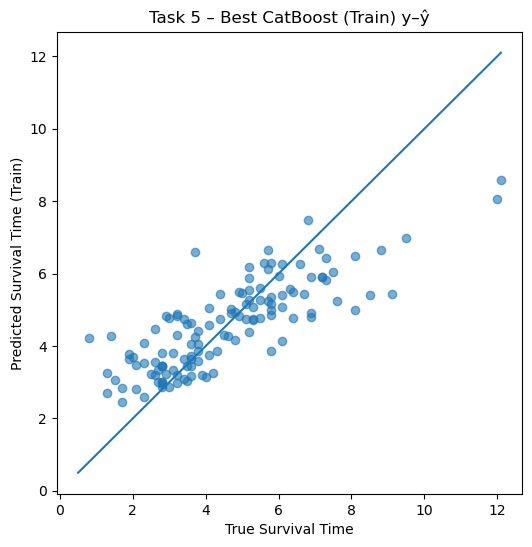

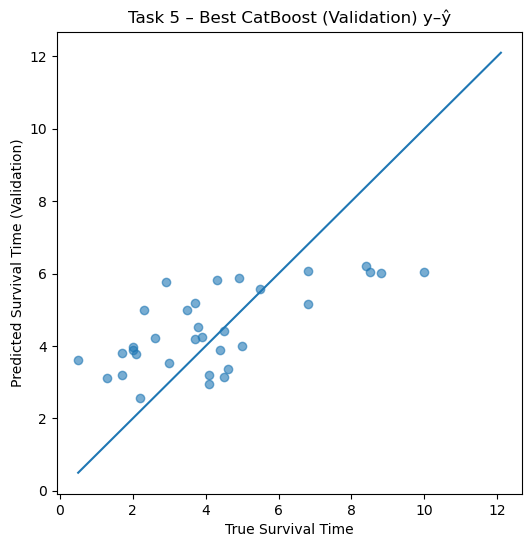


Retraining best CatBoost on ALL supervised data for final predictions...

Task 5 – optional submission saved to: ../outputs/csv/optional-submission-02.csv
Upload this file to Kaggle as: optional-submission-02.csv


In [28]:
# ============================================
# Task 5 – Tuned CatBoostRegressor (no ensemble)
# optional-submission-02.csv
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

print("\n==================== Task 5 – Tuned CatBoost ====================\n")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    Only use uncensored patients with known SurvivalTime
# ------------------------------------------------------------
supervised_mask_5 = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
train_sup_5 = train.loc[supervised_mask_5].copy()

X_sup_5 = train_sup_5[full_feature_cols].values
y_sup_5 = train_sup_5["SurvivalTime"].values

X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_sup_5, y_sup_5, test_size=0.2, random_state=42
)

print(f"Task 5 – supervised rows: {len(X_sup_5)}")
print(f"Train size: {len(X_train_5)},  Val size: {len(X_val_5)}")

# ------------------------------------------------------------
# 2. Hyperparameter search for CatBoostRegressor
#    We try a small grid of (depth, learning_rate, l2_leaf_reg)
# ------------------------------------------------------------
param_grid = {
    "depth":          [4, 6, 8],
    "learning_rate":  [0.03, 0.05, 0.08],
    "l2_leaf_reg":    [1.0, 3.0, 5.0],
}

results_params = []
best_mse = np.inf
best_model_5 = None
best_params = None

counter = 0
total = len(param_grid["depth"]) * len(param_grid["learning_rate"]) * len(param_grid["l2_leaf_reg"])

for d in param_grid["depth"]:
    for lr in param_grid["learning_rate"]:
        for l2 in param_grid["l2_leaf_reg"]:
            counter += 1
            print(f"Training combo {counter}/{total}: depth={d}, lr={lr}, l2_leaf_reg={l2}")

            # CatBoostRegressor with RMSE loss
            model = CatBoostRegressor(
                loss_function="RMSE",
                eval_metric="RMSE",
                iterations=1500,
                learning_rate=lr,
                depth=d,
                l2_leaf_reg=l2,
                random_seed=42,
                verbose=False
            )

            model.fit(X_train_5, y_train_5, eval_set=(X_val_5, y_val_5), verbose=False)

            y_val_pred = model.predict(X_val_5)
            mse_val = mean_squared_error(y_val_5, y_val_pred)
            rmse_val = np.sqrt(mse_val)

            results_params.append({
                "depth": d,
                "learning_rate": lr,
                "l2_leaf_reg": l2,
                "Val_MSE": mse_val,
                "Val_RMSE": rmse_val,
            })

            print(f" -> Val MSE = {mse_val:.4f}, Val RMSE = {rmse_val:.4f}")

            if mse_val < best_mse:
                best_mse = mse_val
                best_model_5 = model
                best_params = (d, lr, l2)

# Put all combinations into a DataFrame for the slides
results_params_df = pd.DataFrame(results_params).sort_values("Val_MSE")
print("\n=== Task 5 – CatBoost hyperparameter search results ===")
print(results_params_df.to_string(index=False))

print("\nBest params:")
print(f" depth        = {best_params[0]}")
print(f" learning_rate= {best_params[1]}")
print(f" l2_leaf_reg  = {best_params[2]}")
print(f" Best Val MSE = {best_mse:.4f}")
print(f" Best Val RMSE= {np.sqrt(best_mse):.4f}")

# ------------------------------------------------------------
# 3. y–ŷ plots for the best CatBoost model
# ------------------------------------------------------------
# Predictions on train and validation sets using best_model_5
y_train_best = best_model_5.predict(X_train_5)
y_val_best   = best_model_5.predict(X_val_5)

plt.figure(figsize=(6,6))
plt.scatter(y_train_5, y_train_best, alpha=0.6)
a, b = y_sup_5.min(), y_sup_5.max()
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Train)")
plt.title("Task 5 – Best CatBoost (Train) y–ŷ")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val_5, y_val_best, alpha=0.6)
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Validation)")
plt.title("Task 5 – Best CatBoost (Validation) y–ŷ")
plt.show()

# ------------------------------------------------------------
# 4. Retrain best CatBoost on ALL supervised data
#    and generate Kaggle file optional-submission-02.csv
# ------------------------------------------------------------
print("\nRetraining best CatBoost on ALL supervised data for final predictions...")

best_depth, best_lr, best_l2 = best_params

final_cat_5 = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    iterations=1500,
    learning_rate=best_lr,
    depth=best_depth,
    l2_leaf_reg=best_l2,
    random_seed=42,
    verbose=False
)

final_cat_5.fit(X_sup_5, y_sup_5)

X_test_5 = test[full_feature_cols].values
test_pred_5 = final_cat_5.predict(X_test_5)

# Save submission
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt2 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_5
})

opt_path2 = "../outputs/csv/optional-submission-02.csv"
sub_opt2.to_csv(opt_path2, index=False)

print(f"\nTask 5 – optional submission saved to: {opt_path2}")
print("Upload this file to Kaggle as: optional-submission-02.csv")



==================== Task 5 – Stacking Ensemble ====================

Total supervised rows (Task 5): 161
Train size (Task 5): 128
Val size   (Task 5): 33

Training stacking ensemble on train split and evaluating on validation split...

Stacking ensemble – validation MSE:  3.4568
Stacking ensemble – validation RMSE: 1.8592


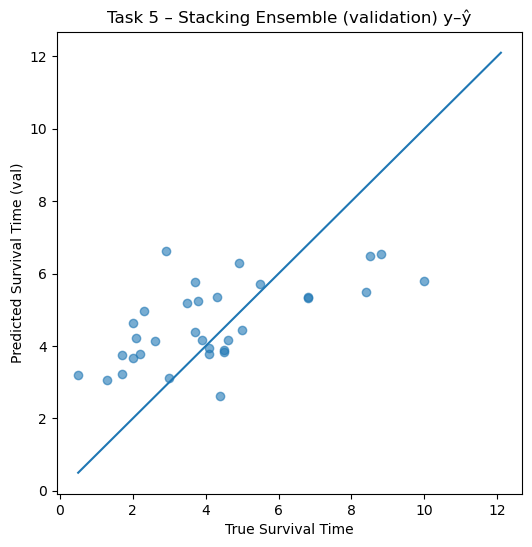


Training final stacking ensemble on ALL supervised data...

Task 5 stacking ensemble submission saved to: ../outputs/csv/optional-submission-06.csv
Submete este ficheiro como: optional-submission-06.csv no Kaggle.


In [34]:
# ================================================
# Task 5 – Stacking Ensemble (sklearn only)
# Gera: optional-submission-06.csv
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor

print("\n==================== Task 5 – Stacking Ensemble ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------

# full_feature_cols (same as in Tasks 3/4)
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# best_imputer from Task 3.1 (if not available, use median)
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# 'train' and 'test' should already be loaded as in previous tasks
if "train" not in globals() or "test" not in globals():
    raise RuntimeError("Variables 'train' and 'test' must be defined (CSVs already loaded).")

# ------------------------------------------------------------
# 1. Supervised dataset for Task 5
#    (Censored == 0 and SurvivalTime not NaN)
# ------------------------------------------------------------
supervised_mask_5 = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask_5].copy()

X_5_raw = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_5_raw.shape[0])

# Impute using the best imputer from Task 3.1
X_5_imp = best_imputer.fit_transform(X_5_raw)

# Hold-out split for local validation
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_5_imp, y_5, test_size=0.2, random_state=42
)

print("Train size (Task 5):", len(X_train_5))
print("Val size   (Task 5):", len(X_val_5))

# ------------------------------------------------------------
# 2. Define base models and stacking ensemble
# ------------------------------------------------------------

# Base learners
base_estimators = [
    ("lin", LinearRegression()),
    ("rf", RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
    ("et", ExtraTreesRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
    ("hgb", HistGradientBoostingRegressor(
        max_iter=400,
        learning_rate=0.05,
        max_depth=None,
        l2_regularization=0.0,
        random_state=42
    )),
]

# Meta-model (on top of base model predictions)
final_estimator = Ridge(alpha=1.0, random_state=42)

stack_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,  # only use base model predictions, not raw X, in meta-model
    n_jobs=-1
)

# ------------------------------------------------------------
# 3. Train and evaluate on validation split
# ------------------------------------------------------------
print("\nTraining stacking ensemble on train split and evaluating on validation split...")

stack_model.fit(X_train_5, y_train_5)
y_val_pred = stack_model.predict(X_val_5)

mse_val = mean_squared_error(y_val_5, y_val_pred)
rmse_val = np.sqrt(mse_val)

print(f"\nStacking ensemble – validation MSE:  {mse_val:.4f}")
print(f"Stacking ensemble – validation RMSE: {rmse_val:.4f}")

# Optional: y–ŷ plot for your report
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_val_5, y_val_pred, alpha=0.6)
min_y, max_y = y_5.min(), y_5.max()
plt.plot([min_y, max_y], [min_y, max_y])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (val)")
plt.title("Task 5 – Stacking Ensemble (validation) y–ŷ")
plt.show()

# ------------------------------------------------------------
# 4. Train final model on ALL supervised data
# ------------------------------------------------------------
print("\nTraining final stacking ensemble on ALL supervised data...")

# Refit imputer on all supervised rows
X_5_imp_all = best_imputer.fit_transform(X_5_raw)

stack_model_final = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,
    n_jobs=-1
)

stack_model_final.fit(X_5_imp_all, y_5)

# ------------------------------------------------------------
# 5. Predict on test set and build Kaggle submission
# ------------------------------------------------------------
X_test_raw_5 = test[full_feature_cols].values
X_test_imp_5 = best_imputer.transform(X_test_raw_5)

y_test_pred_5 = stack_model_final.predict(X_test_imp_5)

# Ensure output directory exists
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt_6 = pd.DataFrame({
    "id": test["id"],
    "0": y_test_pred_5
})

output_path_5_stack = "../outputs/csv/optional-submission-06.csv"
sub_opt_6.to_csv(output_path_5_stack, index=False)

print(f"\nTask 5 stacking ensemble submission saved to: {output_path_5_stack}")
print("Submete este ficheiro como: optional-submission-06.csv no Kaggle.")
